In [424]:
# !pip install pytesseract
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install opencv-python
# !pip install numpy
# !pip install seaborn

# Увеличение датасета

## Медицинские рекмоендации по употреблению молока

Медицинские рекомендации по количеству потребления белков, жиров и углеводов могут немного различаться в зависимости от возраста, пола, физической активности и состояния здоровья человека. Вот общие рекомендации, которые могут быть полезными:

1. **Белки**
   - Обычно рекомендуется потреблять около 0.8-1 г белка на 1 кг массы тела в день для взрослых.
   - Для детей и подростков рекомендации могут варьироваться и могут быть ближе к 1-1.2 г белка на 1 кг массы тела.
   - Для старших людей рекомендуется увеличение потребления белка для поддержания мышечной массы и общего здоровья.
  
2. **Жиры**
   - Рекомендуемый уровень потребления жиров составляет примерно 20-35% от общего количества потребляемых калорий в день.
3. **Углеводы**
   - Рекомендуемый уровень потребления углеводов составляет примерно 45-65% от общего количества потребляемых калорий в день.
  
На основе этих рекоммендаций произошло увеличение датасета. Частично это были человеческие вычисления, частично это было машинное вычисление с помощью OpenAI.

# Объявление переменных датасета и изображения для модели
Сделано для удобной смены датасета и изображения по всём коде

In [425]:
# сбалансированный датасет
IMG_TO_DO="pic8.jpg"
DATASET='data/newDataset.csv'
# несбалансированный датасет
# IMG_TO_DO="pic5.jpg"
# DATASET='data/dataset2.csv'

# Предобработка фотографии для чтения данных
Для предобработки изображения используется библиотека pytesseract, в которую дополнительно загружался русский язык. Изображение, содержащее текст, сканируется и анализируется, чтобы идентифицировать символы в нем. После идентификации символ преобразуется в машинно-кодированный текст

In [426]:

import pytesseract
import cv2
import numpy as np
import re

pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR\\tesseract.exe'


def text_identification(img):
    texts = []
    config = r'--tessdata-dir "C:\Program Files\Tesseract-OCR\tessdata"' 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('res/gray_image.jpg',gray)
    texts.append(pytesseract.image_to_string(gray,  lang = 'rus', config=config))
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    cv2.imwrite('res/threshold_image.jpg',thresh1)
    texts.append(pytesseract.image_to_string(thresh1,  lang = 'rus', config=config))
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 12))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 3)
    cv2.imwrite('res/dilation_image.jpg',dilation)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    im2 = img.copy()
    cropped_text =''
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Рисуем ограничительную рамку на текстовой области
        rect=cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Обрезаем область ограничительной рамки
        cropped = im2[y:y + h, x:x + w]
        cropped_text += pytesseract.image_to_string(cropped,  lang = 'rus', config=config)
        cv2.imwrite('res/rectanglebox.jpg',rect)
    texts.append(cropped_text)
    return texts
  
        
def find_data_in_text(str):
    datas = np.zeros(4)
    regExp = [
    r'\b[Жж][Ии][Ии]?[Рр](а|ы|ов)?(, г|,г)?\s?[—-]?\s?(от)?\s?[0-9]+[,.\s]?[0-9]',
    r'\bбелк(а|и|ов)?(, г|,г)?\s?[—-]?\s?(не менее)?\s?[0-9]+[,.\s]?[0-9]',
    r'\bуглевод(а|ы|ов)?(, г|,г)?\s?[—-]?\s?[0-9]+[,.\s]?[0-9]',
    r'[\d]+(.[\d]+)?\sккал'
    ]

    for i in range(4):
        finded_slice = re.search(regExp[i], str, re.IGNORECASE)
    if finded_slice:
        specific_numbers=re.search(r'\b[0-9]+[,.\s]?[0-9]', finded_slice[0], re.IGNORECASE)
        number = float(specific_numbers[0].replace(",","."))
        if i == 3:
            datas[i] = number
        else:
            datas[i] = number/ 10 if float(specific_numbers[0].replace(",",".")) > 10 else number

    return datas

def result(pic):
    texts = text_identification(cv2.imread("pics/" + pic))
    data = [0, 0, 0, 0]
    flag = 0
    for text in texts:
        image_data = find_data_in_text(text)
        for i in range(4):
            if(data[i] == 0 and image_data[i] != 0):
                flag += 1
                data[i] = image_data[i]
            if flag == 4:
                break
    return data

# Вспомогательные функции вывода

In [427]:
import itertools

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
        
  
def plot_pred_test(pred, test, name_pred, name_test, name_to_save):
    plt.figure(figsize=(10, 5))
    plt.plot(pred, "r--o" , label=name_pred, markersize=12)
    plt.plot(test,"b--o", label=name_test, markersize=7)
    plt.ylabel('ответ на поставленный вопрос (0 - нет, 1 -да)')
    plt.savefig(name_to_save)
    plt.show()
    
  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          name_to_save="res/conf_matrix.png"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    plt.savefig(name_to_save)
    plt.show()

# Загрузка датасета и его анализ

In [428]:
train = pd.read_csv(DATASET) 
    
train_df = train.copy()
train_df.head(10)


,proteins,fats,carbohydrates,calories,height,weight,age,male,lactose allergy,drink
0,2.9,2.5,4.7,53.0,70,175,25,2,1,0
1,2.9,2.5,4.7,53.0,58,163,32,1,1,0
2,2.9,2.5,4.7,53.0,85,187,40,3,1,0
3,2.9,2.5,4.7,53.0,62,158,19,3,1,0
4,2.9,2.5,4.7,53.0,90,195,45,2,1,0
5,2.9,2.5,4.7,53.0,55,170,52,1,1,0
6,2.9,2.5,4.7,53.0,48,160,14,1,1,0
7,2.9,2.5,4.7,53.0,106,200,68,1,1,0
8,2.9,2.5,4.7,53.0,73,157,75,4,1,0
9,2.9,2.5,4.7,53.0,39,135,12,1,1,0


In [429]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6808 entries, 0 to 6807
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   proteins         6808 non-null   float64
 1   fats             6808 non-null   float64
 2   carbohydrates    6808 non-null   float64
 3   calories         6808 non-null   float64
 4   height           6808 non-null   int64  
 5   weight           6808 non-null   int64  
 6   age              6808 non-null   int64  
 7   male             6808 non-null   int64  
 8   lactose allergy  6808 non-null   int64  
 9   drink            6808 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 532.0 KB


Убеждаемся, что датасет хороший, т.к. нет пустых значений или полей

# Статистика по числовым значениям поля

In [430]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
proteins,6808.0,2.665981,0.478690,2.0,2.0,2.9,3.1,3.1
fats,6808.0,2.364336,1.799439,0.1,0.1,2.5,4.5,4.5
carbohydrates,6808.0,4.766701,0.047132,4.7,4.7,4.8,4.8,4.8
calories,6808.0,51.978408,16.759246,31.0,31.0,53.0,72.0,72.0
height,6808.0,78.452409,23.898058,39.0,65.0,65.0,90.0,120.0
weight,6808.0,171.489865,13.958317,135.0,155.0,170.0,190.0,200.0
age,6808.0,48.031874,23.260951,9.0,25.0,40.0,80.0,103.0
male,6808.0,2.612368,1.164584,1.0,1.0,3.0,4.0,4.0
lactose allergy,6808.0,0.490893,0.499954,0.0,0.0,0.0,1.0,1.0
drink,6808.0,0.450646,0.497595,0.0,0.0,0.0,1.0,1.0


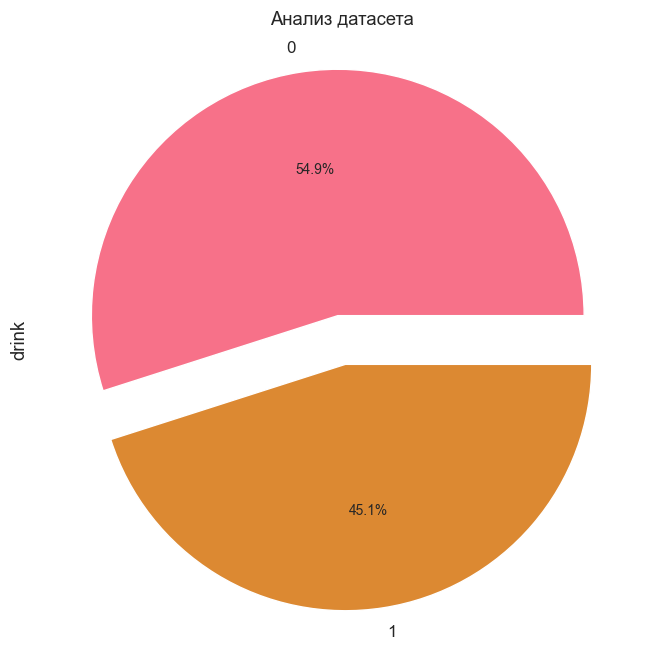

In [431]:
import seaborn as sns

plt.figure(figsize=(8,8))
palette_color = sns.color_palette('husl', 10)
explode = [0.1, 0.1]
train_df.groupby('drink')['drink'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%", title='Анализ датасета');

Датасет получился сбалансированным, что положительно влияет на точность модели и скорость обнаружения

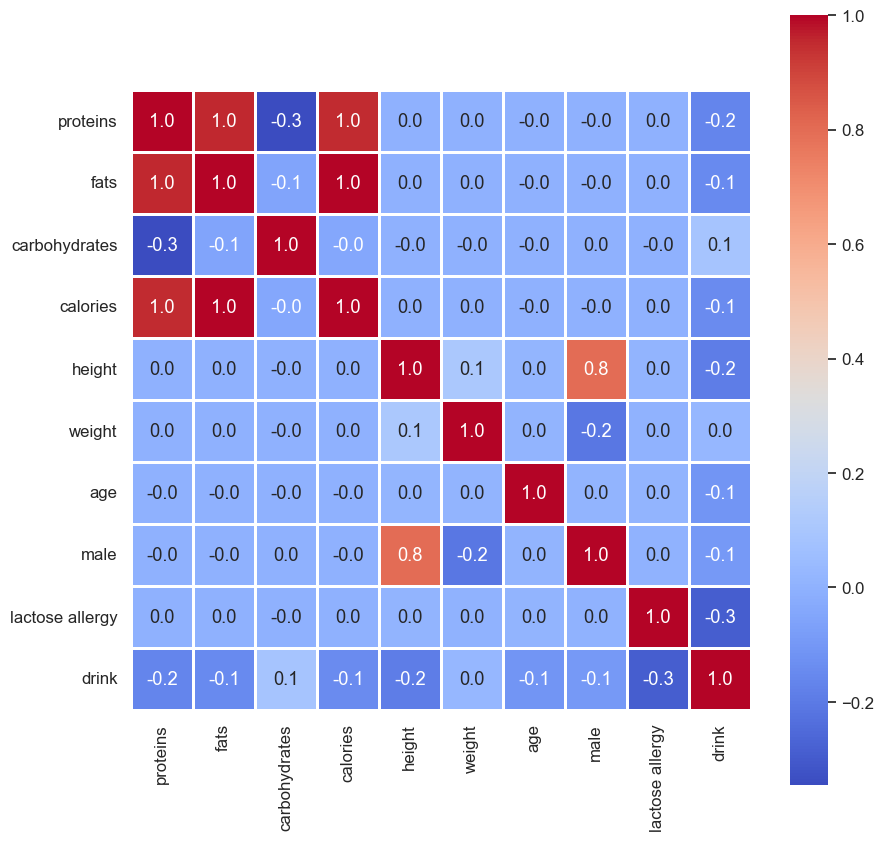

In [432]:
sns.set(font_scale=1.1)
correlation_train = train_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=True);

Мы видим сильную положительную корреляцию с показателями белков, жиров и калорий и отдельно белков и жиров. Также существует некоторая положительная корреляция между полом и ростом

In [433]:
def main_functionality():
    train = pd.read_csv(DATASET) 
  
    X = train.drop(["drink"], axis=1).values
    y = train["drink"].values


    X_tarin, X_test, y_train, y_test = train_test_split(X, y)        

    model = GradientBoostingClassifier()

    model.fit(X_tarin, y_train)

    predict = model.predict(X_test)
    plot_pred_test(predict, y_test, "pred", "test", "res/pred_test_GradientBoostingClassifier.png")

    font = {'size' : 10}
    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, predict)

    plot_confusion_matrix(cnf_matrix, classes=['Нет', 'Да'],
                        title='Матрица Ошибок Для GradientBoostingClassifier', name_to_save="res/conf_matrixGradientBoostingClassifier.png")


    report = classification_report(y_test, predict, target_names=['Нет', 'Да'])
    print(report)

    person = [158, 50, 18, 1, 0]
    milk = result(IMG_TO_DO)
    line = np.array([milk + person])
    print(model.predict(line))

    line_to_dlt_sfx = model.predict(line)
    line_wth_suf = str(line_to_dlt_sfx).removeprefix('[').removesuffix(']')
    
    print(line_wth_suf)
    if line_wth_suf == '1':
        print(line_wth_suf,' - Молоко полезно! Пей и радуйся жизни')
    else:
        print(line_wth_suf, '- Молоко неполезно! Не пей и радуйся жизни')

In [434]:
def tree_function():
    train = pd.read_csv(DATASET) 
  
    X = train.drop(["drink"], axis=1).values
    y = train["drink"].values


    X_tarin, X_test, y_train, y_test = train_test_split(X, y)        

    model = RandomForestClassifier()

    model.fit(X_tarin, y_train)

    predict = model.predict(X_test)
    plot_pred_test(predict, y_test, "pred", "test", "res/pred_test_RandomForestClassifier.png")

    font = {'size' : 10}
    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, predict)

    plot_confusion_matrix(cnf_matrix, classes=['Нет', 'Да'],
                        title='Матрица Ошибок для RandomForestClassifier', name_to_save="res/conf_matrix_RandomForestClassifier.png")


    report = classification_report(y_test, predict, target_names=['Нет', 'Да'])
    print(report)

    person = [158, 50, 18, 1, 0]
    milk = result(IMG_TO_DO)
    line = np.array([milk + person])

    print(model.predict(line))
    line_to_dlt_sfx = model.predict(line)
    line_wth_suf = str(line_to_dlt_sfx).removeprefix('[').removesuffix(']')
    
    print(line_wth_suf)
    if line_wth_suf == '1':
        print(line_wth_suf,' - Молоко полезно! Пей и радуйся жизни')
    else:
        print(line_wth_suf, '- Молоко неполезно! Не пей и радуйся жизни')
    

# Результаты работы для модели GradientBoostingClassifier


GradientBoostingClassifier - это алгоритм машинного обучения, который основан на идее построения ансамбля слабых моделей, таких как деревья решений, в последовательности, где каждая новая модель настраивается на ошибки предыдущих моделей. Основная идея заключается в том, чтобы постепенно улучшать прогноз, минимизируя ошибку потерь. В отличие от Random Forest, где деревья строятся независимо, в Gradient Boosting деревья строятся итеративно, каждое новое дерево настраивается на остатки предыдущего. Это позволяет модели фокусироваться на ошибках предыдущих моделей, делая его более гибким и мощным в некоторых случаях. Однако GradientBoostingClassifier более склонен к переобучению и может быть более чувствителен к настройке гиперпараметров

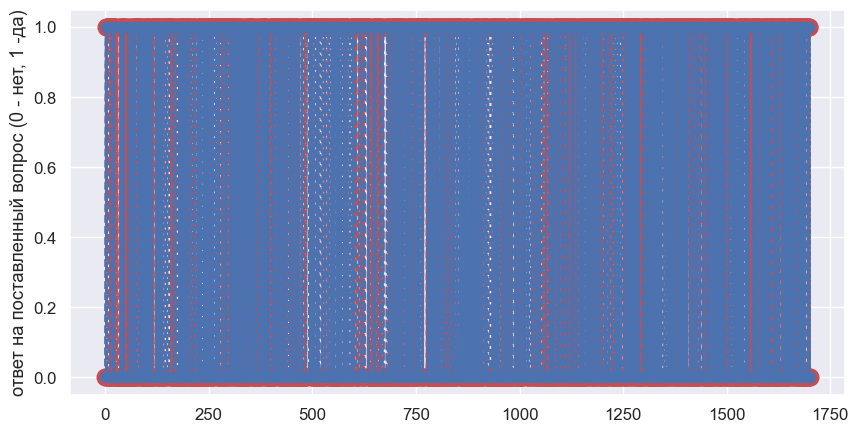

Confusion matrix, without normalization


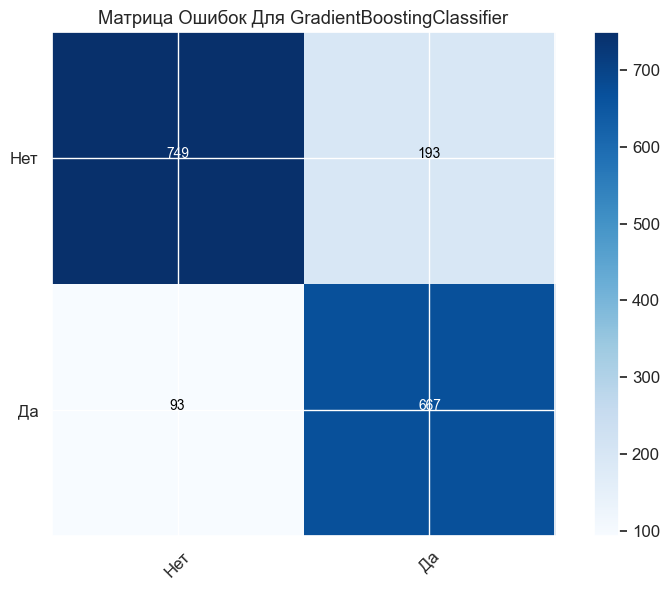

              precision    recall  f1-score   support

         Нет       0.89      0.80      0.84       942
          Да       0.78      0.88      0.82       760

    accuracy                           0.83      1702
   macro avg       0.83      0.84      0.83      1702
weighted avg       0.84      0.83      0.83      1702

[1]
1
1  - Молоко полезно! Пей и радуйся жизни


In [435]:
main_functionality()

# Результаты работы для модели RandomForestClassifier


RandomForestClassifier - это алгоритм машинного обучения, основанный на методе случайного леса. Он использует ансамбль решающих деревьев для задач классификации. Каждое дерево строится на основе случайной подвыборки данных и случайного подмножества признаков. В процессе прогнозирования, каждое дерево голосует за классификацию объекта, и результат определяется путем голосования.

 RandomForestClassifier хорошо масштабируется, устойчив к переобучению и эффективен для работы с большими наборами данных.

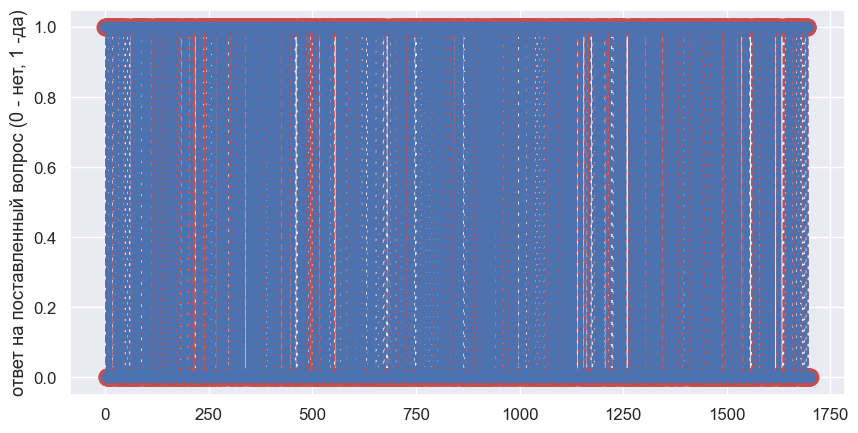

Confusion matrix, without normalization


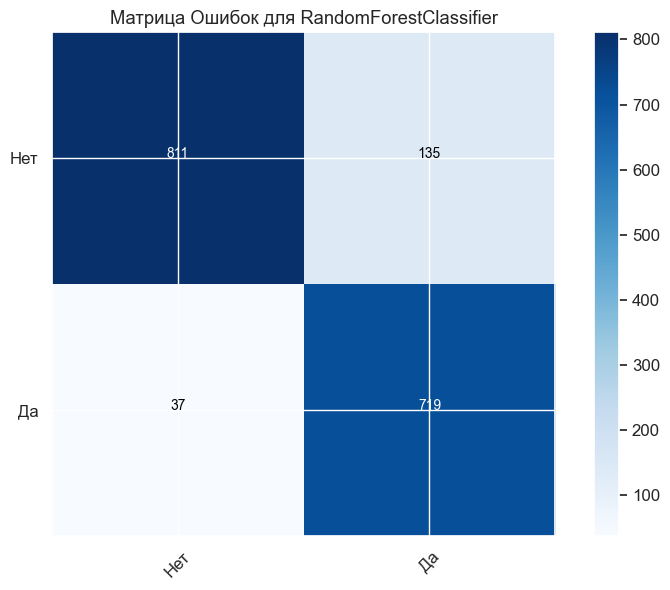

              precision    recall  f1-score   support

         Нет       0.96      0.86      0.90       946
          Да       0.84      0.95      0.89       756

    accuracy                           0.90      1702
   macro avg       0.90      0.90      0.90      1702
weighted avg       0.91      0.90      0.90      1702

[1]
1
1  - Молоко полезно! Пей и радуйся жизни


In [436]:
tree_function()

# Аанализ результатов работы двух моделей
Несмотря на то, что GradientBoosting считается более лучшей моделью, нежели RandomForest, точность у него получилась меньше. Предпологаю, что это связано с большими выбросами разных показателей, т.к. частично это были человеческие препдоложения о полезности молока, а не машинные подсчеты. RandomForest обычно более устойчив к выбросам в данных, так как усредняет прогнозы большого числа деревьев, тогда как GradientBoosting может подстраиваться под выбросы, что может привести к менее точным результатам.

# Используемые метрики

Для исследования моделей была использована функция `classification_report` из библиотеки sklearn (sklearn.metrics). Эта сводка включает в себя следюущие метрики:
1. **Точность (Precision)**:
   - Это процент правильных положительных прогнозов по отношению к общему количеству положительных прогнозов. 
   -  Формула: TP / (TP + FP), где TP - true positive (верно предсказанные положительные), FP - false positive (ложно предсказанные положительные).
 
2. **Полнота (Recall):**
   - Это процент правильных положительных прогнозов по отношению к общему количеству фактических положительных результатов.
   - Формула: TP / (TP + FN), где FN - false negative (ложно предсказанные отрицательные).

3. **F1-мера (F1-score):**
   - Среднее гармоническое между точностью и полнотой. Она является балансом между точностью и полнотой классификации Чем ближе к 1, тем лучше модель..
   - Формула: 2 * (Precision * Recall) / (Precision + Recall)

4. **Поддержка (Support):**
   - Это количество фактических вхождений каждого класса в наборе данных. 
   - Поддержка используется для вычисления средневзвешенных показателей precision, recall и F1.
  
5. **Точность (Accuracy):**
   - Это общая метрика, которая показывает, как часто модель правильно классифицирует объекты. Это полезно для общего понимания производительности модели, особенно если классы в наборе данных сбалансированы.
   - Формула: (TP+TN) / (TP+TN+FP+FN)